In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.0 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import pickle
with open('/kaggle/input/graph-dataset/graph_sequences.pkl', 'rb') as f:
    loaded_graph_sequences = pickle.load(f)


In [4]:
import numpy as np

def normalize_relative_to_ego_1(dataset):
    """
    Normalize dataset where each sample is a tuple of:
    (list of node feature matrices, list of adjacency matrices, list of future coordinates)

    This normalizes:
    - Position features (Local_X, Local_Y) relative to the ego vehicle
    - Future coordinates relative to the ego vehicle at the last observed time step
    - Velocity, Acceleration scaled globally
    - Lane ID scaled to [0, 1]
    """

    normalized_data = []

    for node_features_seq, adj_seq, future_coords in dataset:
        normalized_seq = []

        for t, features in enumerate(node_features_seq):
            features = np.array(features)
            if features.shape[0] == 0 or (features == 0).all():
                normalized_seq.append(features)
                continue

            # Ego vehicle is at index 0
            ego_x, ego_y = features[0, 0], features[0, 1]

            # Normalize position relative to ego
            features[:, 0] -= ego_x  # Local_X
            features[:, 1] -= ego_y  # Local_Y

            # Normalize velocity and acceleration (global scale)
            features[:, 2] /= 100.0  # v_Vel (normalize to ~0-1)
            features[:, 3] /= 10.0   # v_Acc (normalize to ~-1 to 1)

            # Normalize Lane_ID to [0,1] range (assume lanes 1–7)
            features[:, 4] = (features[:, 4] - 1) / 6.0

            normalized_seq.append(features)

        # Normalize future coordinates relative to ego's last known position
        last_ego_x = node_features_seq[-1][0][0]
        last_ego_y = node_features_seq[-1][0][1]
        norm_future_coords = [(x - last_ego_x, y - last_ego_y) for x, y in future_coords]

        normalized_data.append((normalized_seq, adj_seq, norm_future_coords))

    return normalized_data


def normalize_relative_to_ego_2(dataset):
    """
    Improved normalization:
    - Relative position normalization based on ego vehicle
    - Scaled velocity, acceleration using robust global statistics
    - Lane ID scaled to [0, 1]
    - Vectorized future coordinate normalization
    """

    # Collect global statistics for better scaling
    all_velocities = []
    all_accelerations = []

    # First pass to gather stats
    for node_features_seq, _, _ in dataset:
        for features in node_features_seq:
            features = np.array(features)
            if features.shape[0] == 0 or (features == 0).all():
                continue
            all_velocities.extend(features[:, 2])
            all_accelerations.extend(features[:, 3])

    vel_std = np.std(all_velocities) if all_velocities else 1.0
    acc_std = np.std(all_accelerations) if all_accelerations else 1.0

    normalized_data = []

    for node_features_seq, adj_seq, future_coords in dataset:
        normalized_seq = []

        for t, features in enumerate(node_features_seq):
            features = np.array(features)
            if features.shape[0] == 0 or (features == 0).all():
                normalized_seq.append(features)
                continue

            # Ego vehicle at index 0
            ego_x, ego_y = features[0, 0], features[0, 1]

            # Normalize position relative to ego
            features[:, 0] -= ego_x  # Local_X
            features[:, 1] -= ego_y  # Local_Y

            # Normalize velocity and acceleration using std
            features[:, 2] /= (vel_std + 1e-5)  # v_Vel
            features[:, 3] /= (acc_std + 1e-5)  # v_Acc

            # Normalize Lane_ID to [0,1]
            features[:, 4] = (features[:, 4] - 1) / 6.0

            normalized_seq.append(features)

        # Normalize future coordinates relative to ego's last known position
        last_ego_x = node_features_seq[-1][0][0]
        last_ego_y = node_features_seq[-1][0][1]
        future_coords = np.array(future_coords)
        norm_future_coords = future_coords - np.array([last_ego_x, last_ego_y])

        normalized_data.append((normalized_seq, adj_seq, norm_future_coords.tolist()))

    return normalized_data


In [5]:
import numpy as np

def normalize_relative_to_ego(dataset):
    """
    Normalize graph sequence dataset:
    - Position features (Local_X, Local_Y) relative to ego
    - Velocity & acceleration using z-score normalization (global mean & std)
    - Lane ID normalized to [0, 1]
    - Future coordinates normalized relative to ego’s last known position
    - Original feature shape is preserved
    """

    # Collect global statistics
    all_velocities = []
    all_accelerations = []

    for node_features_seq, _, _ in dataset:
        for features in node_features_seq:
            features = np.array(features)
            if features.shape[0] == 0 or (features == 0).all():
                continue
            all_velocities.extend(features[:, 2])
            all_accelerations.extend(features[:, 3])

    vel_mean = np.mean(all_velocities) if all_velocities else 0.0
    vel_std = np.std(all_velocities) if all_velocities else 1.0
    acc_mean = np.mean(all_accelerations) if all_accelerations else 0.0
    acc_std = np.std(all_accelerations) if all_accelerations else 1.0

    normalized_data = []

    for node_features_seq, adj_seq, future_coords in dataset:
        normalized_seq = []

        for features in node_features_seq:
            features = np.array(features)
            if features.shape[0] == 0 or (features == 0).all():
                normalized_seq.append(features)
                continue

            # Ego vehicle assumed at index 0
            ego_x, ego_y = features[0, 0], features[0, 1]

            # Normalize Local_X and Local_Y relative to ego
            features[:, 0] -= ego_x
            features[:, 1] -= ego_y

            # Normalize velocity and acceleration (z-score)
            features[:, 2] = (features[:, 2] - vel_mean) / (vel_std + 1e-5)
            features[:, 3] = (features[:, 3] - acc_mean) / (acc_std + 1e-5)

            # Normalize Lane_ID to [0,1] assuming lanes 1 to 7
            features[:, 4] = (features[:, 4] - 1) / 6.0

            normalized_seq.append(features)

        # Normalize future coordinates relative to last known ego position
        last_ego_x = node_features_seq[-1][0][0]
        last_ego_y = node_features_seq[-1][0][1]
        future_coords = np.array(future_coords)
        norm_future_coords = future_coords - np.array([last_ego_x, last_ego_y])

        normalized_data.append((normalized_seq, adj_seq, norm_future_coords.tolist()))

    return normalized_data


In [6]:
# `original_data` is your list of tuples: (node_features_seq, adj_seq_seq, future_coords)
normalized_data = normalize_relative_to_ego(loaded_graph_sequences)
from sklearn.model_selection import train_test_split
# Now ready for dataset wrapping
train_data, val_data = train_test_split(loaded_graph_sequences, test_size=0.1, random_state=42)
train_data_normalised, val_data_normalised = train_test_split(normalized_data, test_size=0.1, random_state=42)


In [7]:
import torch
from torch_geometric.data import Data, Dataset
import numpy as np

class GraphTrajectoryDataset(Dataset):
    def __init__(self, raw_data):
        self.data = raw_data  # list of (feature_seq, adj_seq, future_coords)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        feature_seq, adj_seq, future_coords = self.data[idx]
        graph_seq = []
    
        for x, a in zip(feature_seq, adj_seq):
            x_tensor = torch.tensor(x, dtype=torch.float32)  # [N, F]
    
            # Detect valid (non-padded) nodes
            valid_mask = ~(x_tensor == 0).all(dim=1)
            valid_indices = valid_mask.nonzero(as_tuple=True)[0]
            num_valid = valid_indices.shape[0]
    
            # Edge filtering
            a = np.array(a)
            a = a[:num_valid, :num_valid]  # crop adjacency to valid nodes only
            edge_index = torch.tensor(np.array((a > 0).nonzero())).long()  # [2, E]
    
            graph_seq.append(Data(x=x_tensor[:num_valid], edge_index=edge_index))
        # Ensure it's exactly 4 points
        while len(future_coords) < 4:
            future_coords.append(future_coords[-1])  # Repeat last coordinate or use (0,0)

        future_coords = torch.tensor(future_coords, dtype=torch.float32)  # [4, 2]
        return graph_seq, future_coords


In [8]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class GATGRUWithSocialPooling(nn.Module):
    def __init__(self, in_channels, hidden_dim, gat_heads=1, gru_layers=1, future_steps=4):
        super(GATGRUWithSocialPooling, self).__init__()

        self.hidden_dim = hidden_dim
        self.future_steps = future_steps

        # GAT layer to get node embeddings from the graph
        self.gat = GATConv(in_channels, hidden_dim, heads=gat_heads, concat=False)

        # MLP for pooling social context from other agents
        self.social_pooling = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # GRU encoder for the sequence of social-aware ego embeddings
        self.encoder_gru = nn.GRU(input_size=hidden_dim * 2, hidden_size=hidden_dim,
                                  num_layers=gru_layers, batch_first=True)

        # GRU decoder for autoregressive prediction
        self.decoder_gru = nn.GRU(input_size=2, hidden_size=hidden_dim,
                                  num_layers=gru_layers, batch_first=True)

        # Output layer for (x, y) prediction
        self.fc_out = nn.Linear(hidden_dim, 2)

    # Fix forward in your model definition
    def forward(self, feat_seq, adj_seq):
        graph_seq = []
        for x, a in zip(feat_seq, adj_seq):
            x_tensor = torch.tensor(x, dtype=torch.float32)
            a = np.array(a)
            valid_mask = ~(x_tensor == 0).all(dim=1)
            num_valid = valid_mask.sum().item()
            a = a[:num_valid, :num_valid]
            edge_index = torch.tensor(np.array((a > 0).nonzero())).long()
            graph_seq.append(Data(x=x_tensor[:num_valid], edge_index=edge_index).to(self.device))
    
        return self.forward(graph_seq)
    

    def forward(self, graph_seq):
        device = self.fc_out.weight.device
        gat_outputs = []

        for graph in graph_seq:
            x, edge_index = graph.x.to(device), graph.edge_index.to(device)
            h = self.gat(x, edge_index)  # GAT outputs for all agents

            # Ego embedding: node 0
            ego_embed = h[0]

            # Social context: aggregate all other agents
            others = h[1:]  # assume node 0 is ego
            if others.shape[0] > 0:
                pooled = self.social_pooling(others).mean(dim=0)
            else:
                pooled = torch.zeros_like(ego_embed)

            # Concatenate ego and pooled context
            ego_social = torch.cat([ego_embed, pooled], dim=0)
            gat_outputs.append(ego_social)

        encoder_input = torch.stack(gat_outputs).unsqueeze(0)  # [1, seq_len, 2*hidden_dim]
        _, hidden = self.encoder_gru(encoder_input)

        # Decoder
        decoder_input = torch.zeros((1, 1, 2), device=device)
        preds = []

        for _ in range(self.future_steps):
            out, hidden = self.decoder_gru(decoder_input, hidden)
            pred = self.fc_out(out.squeeze(1))
            preds.append(pred)
            decoder_input = pred.unsqueeze(1)

        return torch.stack(preds, dim=1).squeeze(0)


In [9]:
# import torch.nn as nn
# from torch_geometric.nn import GATConv

# class GATGRUEncoderDecoder(nn.Module):
#     def __init__(self, in_channels, hidden_dim, num_layers=1):
#         super().__init__()
#         self.gat = GATConv(in_channels, hidden_dim, heads=1, concat=False)
#         self.encoder_gru = nn.GRU(hidden_dim, hidden_dim, num_layers)
#         self.decoder_gru = nn.GRU(2, hidden_dim, num_layers)
#         self.fc_out = nn.Linear(hidden_dim, 2)

#     def forward(self, graph_seq):
#         gat_outputs = []
#         for graph in graph_seq:
#             x, edge_index = graph.x.to(self.fc_out.weight.device), graph.edge_index.to(self.fc_out.weight.device)
#             h = self.gat(x, edge_index)  # [N, hidden]
#             gat_outputs.append(h[0])     # use ego vehicle (index 0)

#         encoder_input = torch.stack(gat_outputs).unsqueeze(1)  # [T, 1, hidden]
#         _, hidden = self.encoder_gru(encoder_input)            # [1, 1, hidden]

#         decoder_input = torch.zeros((1, 1, 2), device=hidden.device)  # Start token
#         outputs = []

#         for _ in range(4):  # Predict 4 time steps
#             out, hidden = self.decoder_gru(decoder_input, hidden)
#             coord = self.fc_out(out.squeeze(0))  # [1, 2]
#             outputs.append(coord)
#             decoder_input = coord.unsqueeze(0)

#         return torch.stack(outputs, dim=0).squeeze(1)  # [4, 2]

import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class GATGRUEncoderDecoder(nn.Module):
    def __init__(self, in_channels, hidden_dim, num_layers=1, dropout=0.3):
        super().__init__()
        self.gat = GATConv(in_channels, hidden_dim, heads=1, concat=False)
        self.encoder_gru = nn.GRU(hidden_dim, hidden_dim, num_layers, dropout=dropout if num_layers > 1 else 0)
        self.decoder_gru = nn.GRU(2, hidden_dim, num_layers, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, 2)

    def forward(self, graph_seq):
        gat_outputs = []
        for graph in graph_seq:
            x, edge_index = graph.x.to(self.fc_out.weight.device), graph.edge_index.to(self.fc_out.weight.device)
            h = self.gat(x, edge_index)         # [N, hidden]
            h = self.dropout(h)                 # Apply dropout
            gat_outputs.append(h[0])            # use ego vehicle (index 0)

        encoder_input = torch.stack(gat_outputs).unsqueeze(1)  # [T, 1, hidden]
        _, hidden = self.encoder_gru(encoder_input)            # [1, 1, hidden]

        decoder_input = torch.zeros((1, 1, 2), device=hidden.device)  # Start token
        outputs = []

        for _ in range(4):  # Predict 4 time steps
            out, hidden = self.decoder_gru(decoder_input, hidden)
            out = self.dropout(out)               # Apply dropout to GRU output
            coord = self.fc_out(out.squeeze(0))   # [1, 2]
            outputs.append(coord)
            decoder_input = coord.unsqueeze(0)

        return torch.stack(outputs, dim=0).squeeze(1)  # [4, 2]


In [10]:
def graph_sequence_collate(batch):
    """
    Custom collate function to support list of sequences of torch_geometric Data.
    """
    batched_graph_seqs = []
    future_coords_list = []

    for graph_seq, future_coords in batch:
        batched_graph_seqs.append(graph_seq)
        future_coords_list.append(future_coords)

    return batched_graph_seqs, torch.stack(future_coords_list)


In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for graph_seqs, future_coords_batch in dataloader:
        graph_seq = [g.to(device) for g in graph_seqs[0]]           # batch size = 1
        future_coords = future_coords_batch[0].to(device)           # [4, 2]

        optimizer.zero_grad()
        pred = model(graph_seq)                                     # [4, 2]
        loss = criterion(pred, future_coords)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return model, total_loss / len(dataloader)


from torch.utils.data import DataLoader

# Assuming you already have your processed dataset:
# raw_data = list of (feature_seq, adj_seq, future_coords)
# Each feature_seq = list of 5 [N x 5] arrays
# Each adj_seq = list of 5 [N x N] arrays
# Each future_coords = list of 4 (x, y) tuples

# Example:
# raw_data = [ (feature_seq_1, adj_seq_1, future_coords_1), ... ]

dataset = GraphTrajectoryDataset(train_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)

model = GATGRUWithSocialPooling(in_channels=5, hidden_dim=64).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# for epoch in range(10):
#     loss = train_one_epoch(model, dataloader, optimizer, criterion, device="cuda")
#     print(f"Epoch {epoch+1}, Loss: {loss:.4f}")


In [12]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses=None):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", color='blue')
    if val_losses is not None:
        plt.plot(val_losses, label="Validation Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.title("Training Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


In [13]:
import torch

def compute_ade_fde(pred, target):
    """
    pred, target: [T x 2] tensors
    """
    ade = torch.norm(pred - target, dim=1).mean().item()
    fde = torch.norm(pred[-1] - target[-1]).item()
    return ade, fde


In [14]:
def visualize_prediction(model, sample, device="cuda"):
    import matplotlib.pyplot as plt

    model.eval()
    node_features_seq, adj_seq, future_coords = sample

    # Move graph sequence to device
    graph_seq = []
    for x, adj in zip(node_features_seq, adj_seq):
        x_tensor = torch.tensor(x, dtype=torch.float32)
        edge_index = torch.tensor(np.array((adj > 0).nonzero())).long()
        graph_seq.append(Data(x=x_tensor, edge_index=edge_index).to(device))

    future_coords = torch.tensor(future_coords, dtype=torch.float32).to(device)

    with torch.no_grad():
        pred_coords = model(graph_seq).cpu()

    # Convert to numpy for plotting
    pred = pred_coords.numpy()
    target = future_coords.cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.plot(target[:, 0], target[:, 1], 'o--', label="Ground Truth", color='green')
    plt.plot(pred[:, 0], pred[:, 1], 'x--', label="Predicted", color='red')
    plt.xlabel("ΔX (ft)")
    plt.ylabel("ΔY (ft)")
    plt.title("Trajectory Prediction")
    plt.legend()
    plt.grid(True)
    plt.axis("equal")
    plt.show()

    ade, fde = compute_ade_fde(pred_coords, future_coords.cpu())
    print(f"Average Displacement Error (ADE): {ade:.3f} ft")
    print(f"Final Displacement Error (FDE): {fde:.3f} ft")
    return target, pred

In [15]:
def evaluate_model(model, val_dataset, device="cuda"):
    model.eval()
    total_ade, total_fde = 0.0, 0.0

    with torch.no_grad():
        for sample in val_dataset:
            feature_seq, adj_seq, future_coords = sample

            # Create graph sequence
            graph_seq = []
            for x, a in zip(feature_seq, adj_seq):
                x_tensor = torch.tensor(x, dtype=torch.float32)
                a = np.array(a)
                valid_mask = ~(x_tensor == 0).all(dim=1)
                num_valid = valid_mask.sum().item()
                a = a[:num_valid, :num_valid]
                edge_index = torch.tensor(np.array((a > 0).nonzero())).long()
                graph_seq.append(Data(x=x_tensor[:num_valid], edge_index=edge_index).to(device))

            target = torch.tensor(future_coords, dtype=torch.float32).to(device)
            pred = model(graph_seq)

            ade, fde = compute_ade_fde(pred, target)
            total_ade += ade
            total_fde += fde

    avg_ade = total_ade / len(val_dataset)
    avg_fde = total_fde / len(val_dataset)
    return avg_ade, avg_fde


In [18]:
ade_list = []
fde_list = []

dataset = GraphTrajectoryDataset(train_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)

for epoch in range(20):
    model, loss = train_one_epoch(model, dataloader, optimizer, criterion, device="cuda")
    train_losses.append(loss)

    ade, fde = evaluate_model(model, val_data, device="cuda")
    ade_list.append(ade)
    fde_list.append(fde)
    model = model
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, ADE: {ade:.3f}, FDE: {fde:.3f}")


NameError: name 'train_losses' is not defined

In [19]:
def plot_ade_fde(ade_list, fde_list):
    plt.figure(figsize=(8, 5))
    plt.plot(ade_list, label="ADE", color='blue')
    plt.plot(fde_list, label="FDE", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Displacement Error (ft)")
    plt.title("Validation ADE/FDE Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_ade_fde(ade_list, fde_list)

NameError: name 'ade_list' is not defined

In [28]:
def train(model, dataloader, optimizer, criterion, tf, device):
    model.train()
    total_loss = 0

    for graph_seqs, future_coords_batch in dataloader:
        # NOTE: batch size is 1, so unpack directly
        graph_seq = [g.to(device) for g in graph_seqs[0]]             # list of graphs
        future_coords = future_coords_batch[0].to(device).unsqueeze(0)  # [1, 4, 2]

        optimizer.zero_grad()
        if tf == 'Yes':
            pred = model(graph_seq, target_seq=future_coords)         # [4, 2]
        else: 
            pred = model(graph_seq)
        loss = criterion(pred, future_coords.squeeze(0))              # [4, 2]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return model, total_loss / len(dataloader)

In [29]:
def train_and_evaluate(model, metric, train_dataset, val_dataset, tf = "No", device="cuda", epochs=20, lr=1e-3):
    from torch.utils.data import DataLoader
    # Prepare training data loader
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)
    # Optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if metric == 'mse':
        criterion = nn.MSELoss()
    else:
        criterion = torch.nn.SmoothL1Loss()  # Huber loss

    # Training loop
    train_losses = []
    for epoch in range(epochs):
        model, loss = train(model, dataloader, optimizer, criterion, tf, device)
        train_losses.append(loss)
        model = model
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss:.4f}")

    # Plot training loss
    plot_loss(train_losses)

    # Final evaluation
    ade, fde = evaluate_model(model, val_dataset, device)
    print(f"\nFinal Evaluation on Validation Set:")
    print(f"Average Displacement Error (ADE): {ade:.3f} ft")
    print(f"Final Displacement Error (FDE): {fde:.3f} ft")

    # Plot predicted vs true trajectory for one sample
    # visualize_prediction(model, val_dataset[0], device)

    return model
model = GATGRUWithSocialPooling(in_channels=5, hidden_dim=64).to("cuda")
# trained_model = train_and_evaluate(model, metric = 'mse', train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=5)


In [37]:
from copy import deepcopy

Socialpooling_model_mse = deepcopy(trained_model).to("cuda")

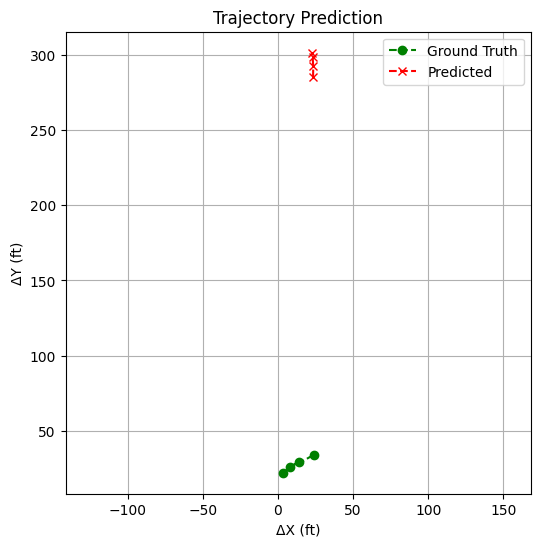

Average Displacement Error (ADE): 266.835 ft
Final Displacement Error (FDE): 275.740 ft


In [33]:
# Visualize the first validation sample
true_coords, pred_coords = visualize_prediction(trained_model, val_data[0], device="cuda")

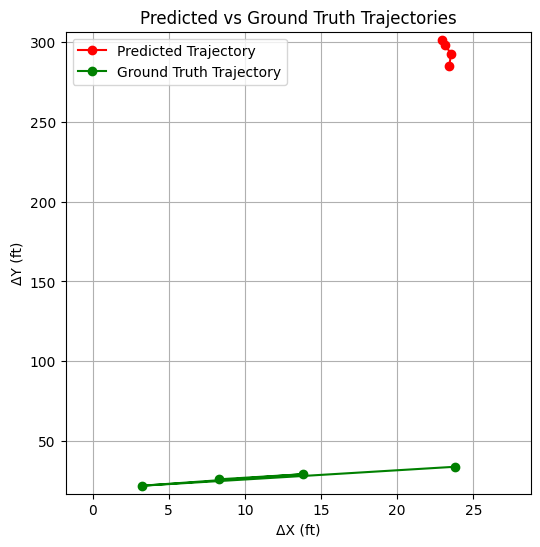

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_trajectories(pred_coords, true_coords, save_as_gif=False):
    """
    Animate predicted vs. actual future trajectories.
    
    Args:
    - pred_coords: numpy array of shape [H, 2], predicted (x, y) positions
    - true_coords: numpy array of shape [H, 2], ground truth (x, y) positions
    - save_as_gif: if True, saves the animation as a GIF
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.set_xlim(min(true_coords[:,0].min(), pred_coords[:,0].min()) - 5, 
                max(true_coords[:,0].max(), pred_coords[:,0].max()) + 5)
    ax.set_ylim(min(true_coords[:,1].min(), pred_coords[:,1].min()) - 5, 
                max(true_coords[:,1].max(), pred_coords[:,1].max()) + 5)
    ax.set_xlabel("ΔX (ft)")
    ax.set_ylabel("ΔY (ft)")
    ax.set_title("Predicted vs Ground Truth Trajectories")
    ax.grid(True)
    
    pred_line, = ax.plot([], [], 'r-o', label='Predicted Trajectory')
    true_line, = ax.plot([], [], 'g-o', label='Ground Truth Trajectory')
    
    ax.legend()

    def init():
        pred_line.set_data([], [])
        true_line.set_data([], [])
        return pred_line, true_line

    def update(frame):
        pred_line.set_data(pred_coords[:frame+1, 0], pred_coords[:frame+1, 1])
        true_line.set_data(true_coords[:frame+1, 0], true_coords[:frame+1, 1])
        return pred_line, true_line

    ani = animation.FuncAnimation(fig, update, frames=len(pred_coords),
                                   init_func=init, blit=True, interval=500, repeat=False)

    if save_as_gif:
        ani.save('trajectory_animation.gif', writer='pillow', fps=2)
    else:
        plt.show()

# Example usage:
# pred_coords = np.array([[0,0],[1,1],[2,2],[3,3]])   # shape (4,2)
# true_coords = np.array([[0,0],[1,1.2],[2,1.9],[3,3.1]])

animate_trajectories(pred_coords, true_coords, save_as_gif=True)


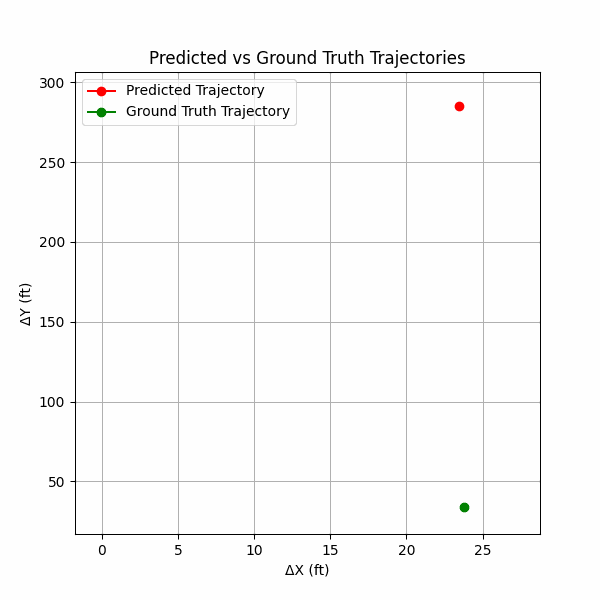

In [35]:
from IPython.display import Image

# Display the saved GIF
Image(filename="trajectory_animation.gif")


**########################**

**Attention model with teacher forcing**

In [19]:
# import torch
# import torch.nn as nn
# from torch_geometric.nn import GATConv
# import random

# class GATGRUWithAttention(nn.Module):
#     def __init__(self, in_channels, hidden_dim, gat_heads=1, gru_layers=1, future_steps=4, teacher_forcing_ratio=0.5):
#         super(GATGRUWithAttention, self).__init__()

#         self.hidden_dim = hidden_dim
#         self.future_steps = future_steps
#         self.teacher_forcing_ratio = teacher_forcing_ratio

#         self.gat = GATConv(in_channels, hidden_dim, heads=gat_heads, concat=False)

#         self.social_pooling = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim)
#         )

#         self.encoder_gru = nn.GRU(input_size=2 * hidden_dim, hidden_size=hidden_dim,
#                                   num_layers=gru_layers, batch_first=True)

#         self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=2, batch_first=True)

#         self.decoder_gru = nn.GRU(input_size=2 + hidden_dim, hidden_size=hidden_dim,
#                                   num_layers=gru_layers, batch_first=True)

#         self.fc_out = nn.Linear(hidden_dim, 2)

#     def forward(self, graph_seq, target_seq=None):
#         device = self.fc_out.weight.device
#         gat_outputs = []

#         # ----- GAT + Social Pooling -----
#         for graph in graph_seq:
#             x, edge_index = graph.x.to(device), graph.edge_index.to(device)
#             h = self.gat(x, edge_index)

#             ego_embed = h[0]
#             others = h[1:]

#             if others.shape[0] > 0:
#                 pooled = self.social_pooling(others).mean(dim=0)
#             else:
#                 pooled = torch.zeros_like(ego_embed)

#             ego_social = torch.cat([ego_embed, pooled], dim=0)
#             gat_outputs.append(ego_social)

#         encoder_input = torch.stack(gat_outputs).unsqueeze(0)  # [1, T, 2*hidden_dim]
#         encoder_outputs, hidden = self.encoder_gru(encoder_input)

#         # ----- Decoder with Teacher Forcing -----
#         decoder_input = torch.zeros((1, 1, 2), device=device)
#         preds = []

#         for t in range(self.future_steps):
#             query = hidden[-1].unsqueeze(1)
#             context, _ = self.attn(query, encoder_outputs, encoder_outputs)

#             decoder_step_input = torch.cat([decoder_input, context], dim=-1)
#             out, hidden = self.decoder_gru(decoder_step_input, hidden)
#             pred = self.fc_out(out.squeeze(1))  # [1, 2]
#             preds.append(pred)

#             # Teacher forcing decision
#             if target_seq is not None and random.random() < self.teacher_forcing_ratio:
#                 decoder_input = target_seq[:, t].unsqueeze(1)  # ground truth at time t
#             else:
#                 decoder_input = pred.unsqueeze(1)  # model prediction

#         return torch.stack(preds, dim=1).squeeze(0)  # [future_steps, 2]


In [30]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv
import random

class GATGRUWithAttention(nn.Module):
    def __init__(self, in_channels, hidden_dim, gat_heads=1, gru_layers=1,
                 future_steps=4, teacher_forcing_ratio=0.5, dropout=0.3):
        super(GATGRUWithAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.future_steps = future_steps
        self.teacher_forcing_ratio = teacher_forcing_ratio

        self.gat = GATConv(in_channels, hidden_dim, heads=gat_heads, concat=False)
        self.gat_dropout = nn.Dropout(dropout)

        self.social_pooling = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.encoder_gru = nn.GRU(input_size=2 * hidden_dim, hidden_size=hidden_dim,
                                  num_layers=gru_layers, batch_first=True, dropout=dropout if gru_layers > 1 else 0)
        self.encoder_ln = nn.LayerNorm(hidden_dim)

        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=2, batch_first=True, dropout=dropout)
        self.attn_ln = nn.LayerNorm(hidden_dim)

        self.decoder_gru = nn.GRU(input_size=2 + hidden_dim, hidden_size=hidden_dim,
                                  num_layers=gru_layers, batch_first=True, dropout=dropout if gru_layers > 1 else 0)
        self.decoder_ln = nn.LayerNorm(hidden_dim)

        self.fc_out = nn.Linear(hidden_dim, 2)
        self.output_dropout = nn.Dropout(dropout)

        # Optional: Initialize weights
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc_out.weight)
        if self.fc_out.bias is not None:
            self.fc_out.bias.data.fill_(0.0)

    def forward(self, graph_seq, target_seq=None):
        device = self.fc_out.weight.device
        gat_outputs = []

        # ----- GAT + Social Pooling -----
        for graph in graph_seq:
            x, edge_index = graph.x.to(device), graph.edge_index.to(device)
            h = self.gat(x, edge_index)
            h = self.gat_dropout(h)

            ego_embed = h[0]
            others = h[1:]

            if others.shape[0] > 0:
                pooled = self.social_pooling(others).mean(dim=0)
            else:
                pooled = torch.zeros_like(ego_embed)

            ego_social = torch.cat([ego_embed, pooled], dim=0)
            gat_outputs.append(ego_social)

        encoder_input = torch.stack(gat_outputs).unsqueeze(0)  # [1, T, 2*hidden_dim]
        encoder_outputs, hidden = self.encoder_gru(encoder_input)  # [1, T, H], [num_layers, 1, H]
        encoder_outputs = self.encoder_ln(encoder_outputs)

        # ----- Decoder with Teacher Forcing -----
        decoder_input = torch.zeros((1, 1, 2), device=device)
        preds = []

        for t in range(self.future_steps):
            query = hidden[-1].unsqueeze(1)  # [1, 1, H]
            context, _ = self.attn(query, encoder_outputs, encoder_outputs)
            context = self.attn_ln(context)

            decoder_step_input = torch.cat([decoder_input, context], dim=-1)
            out, hidden = self.decoder_gru(decoder_step_input, hidden)
            out = self.decoder_ln(out)
            pred = self.fc_out(self.output_dropout(out.squeeze(1)))  # [1, 2]
            preds.append(pred)

            # Teacher forcing
            if target_seq is not None and random.random() < self.teacher_forcing_ratio:
                decoder_input = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input = pred.unsqueeze(1)

        return torch.stack(preds, dim=1).squeeze(0)  # [future_steps, 2]


In [39]:

    
Attn_model = GATGRUWithAttention(in_channels=5, hidden_dim=64, future_steps=4, teacher_forcing_ratio=0.5).to("cuda")
optimizer = torch.optim.Adam(Attn_model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

criterion = torch.nn.SmoothL1Loss()  # Huber loss
TORCH_USE_CUDA_DSA=1

dataset = GraphTrajectoryDataset(train_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)

dataset_normalised = GraphTrajectoryDataset(train_data_normalised)
dataloader_normalised = DataLoader(dataset_normalised, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)
# val_data_normalised


# train_losses = []
# for epoch in range(20):
#     Attn_model, avg_loss = train_one_epoch(Attn_model, dataloader_normalised, optimizer, criterion, device="cuda")
#     # Attn_model, avg_loss = train_one_epoch(Attn_model, dataloader, optimizer, criterion, device="cuda")
#     print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
#     Attn_model = Attn_model
#     train_losses.append(avg_loss)
# plot_loss(train_losses)

SyntaxError: expected ':' (133853915.py, line 11)

In [26]:
ade, fde = evaluate_model(Attn_model, val_data, device="cuda")
print(f"\nFinal Evaluation on Validation Set:")
print(f"Average Displacement Error (ADE): {ade:.3f} ft")
print(f"Final Displacement Error (FDE): {fde:.3f} ft")



Final Evaluation on Validation Set:
Average Displacement Error (ADE): 395.586 ft
Final Displacement Error (FDE): 405.271 ft


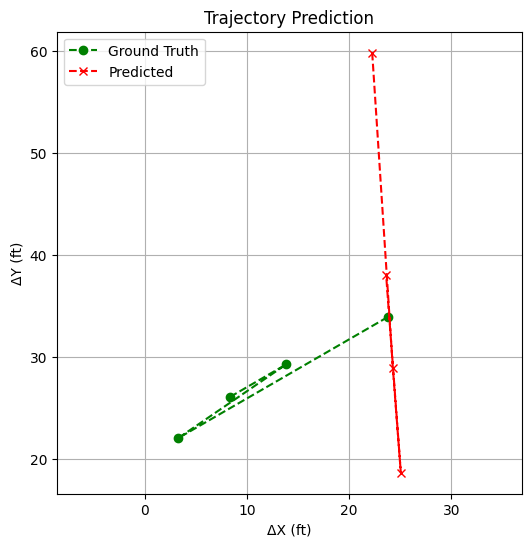

Average Displacement Error (ADE): 20.723 ft
Final Displacement Error (FDE): 19.411 ft


In [27]:
true_coords, pred_coords = visualize_prediction(Attn_model, val_data[0], device="cuda")

**Model Training**

In [31]:
model1 = GATGRUEncoderDecoder(in_channels=5, hidden_dim=64).to("cuda")
model2 = GATGRUWithSocialPooling(in_channels=5, hidden_dim=64).to("cuda")
Attn_model = GATGRUWithAttention(in_channels=5, hidden_dim=64, future_steps=4, teacher_forcing_ratio=0.5).to("cuda")
# optimizer = torch.optim.Adam(Attn_model.parameters(), lr=1e-3)
criterion = torch.nn.SmoothL1Loss()  # Huber loss
TORCH_USE_CUDA_DSA=1

dataset = GraphTrajectoryDataset(train_data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)

dataset_normalised = GraphTrajectoryDataset(train_data_normalised)
dataloader_normalised = DataLoader(dataset_normalised, batch_size=1, shuffle=True, collate_fn=graph_sequence_collate)
# val_data_normalised

# trained_model = train_and_evaluate(Attn_model, train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=20)


Epoch 1/30 | Train Loss: 360094.4201
Epoch 2/30 | Train Loss: 314533.1213
Epoch 3/30 | Train Loss: 276262.2260
Epoch 4/30 | Train Loss: 243115.3243
Epoch 5/30 | Train Loss: 215392.0354
Epoch 6/30 | Train Loss: 191800.6960
Epoch 7/30 | Train Loss: 172247.6699
Epoch 8/30 | Train Loss: 155295.4201
Epoch 9/30 | Train Loss: 142760.2159
Epoch 10/30 | Train Loss: 131440.3309
Epoch 11/30 | Train Loss: 121539.4983
Epoch 12/30 | Train Loss: 114893.8603
Epoch 13/30 | Train Loss: 109822.5870
Epoch 14/30 | Train Loss: 105278.0941
Epoch 15/30 | Train Loss: 101270.7861
Epoch 16/30 | Train Loss: 100283.9397
Epoch 17/30 | Train Loss: 98800.3206
Epoch 18/30 | Train Loss: 96577.3105
Epoch 19/30 | Train Loss: 95228.8735
Epoch 20/30 | Train Loss: 93618.2054
Epoch 21/30 | Train Loss: 92109.3306
Epoch 22/30 | Train Loss: 90927.7537
Epoch 23/30 | Train Loss: 90451.1825
Epoch 24/30 | Train Loss: 89528.1940
Epoch 25/30 | Train Loss: 91370.8748
Epoch 26/30 | Train Loss: 90340.8740
Epoch 27/30 | Train Loss: 86677

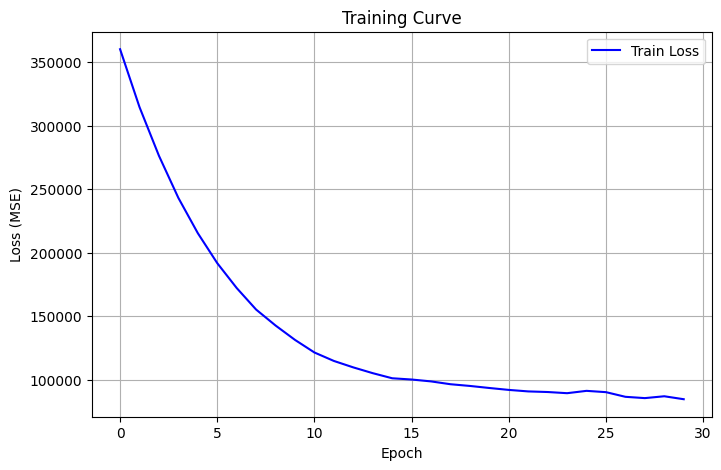


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 337.890 ft
Final Displacement Error (FDE): 370.271 ft
Epoch 1/30 | Train Loss: 84034.3224
Epoch 2/30 | Train Loss: 83445.2415
Epoch 3/30 | Train Loss: 84877.3270
Epoch 4/30 | Train Loss: 82918.7383
Epoch 5/30 | Train Loss: 83719.5219
Epoch 6/30 | Train Loss: 83105.3740
Epoch 7/30 | Train Loss: 82482.4182
Epoch 8/30 | Train Loss: 83554.8925
Epoch 9/30 | Train Loss: 83660.1299
Epoch 10/30 | Train Loss: 82531.7699
Epoch 11/30 | Train Loss: 81935.9485
Epoch 12/30 | Train Loss: 80831.5240
Epoch 13/30 | Train Loss: 81323.8952
Epoch 14/30 | Train Loss: 81957.2350
Epoch 15/30 | Train Loss: 81587.4919
Epoch 16/30 | Train Loss: 82288.1303
Epoch 17/30 | Train Loss: 81051.1682
Epoch 18/30 | Train Loss: 79344.8512
Epoch 19/30 | Train Loss: 79289.8797
Epoch 20/30 | Train Loss: 76043.6244
Epoch 21/30 | Train Loss: 79040.8147
Epoch 22/30 | Train Loss: 79478.2754
Epoch 23/30 | Train Loss: 77538.4123
Epoch 24/30 | Train Loss: 79645.1

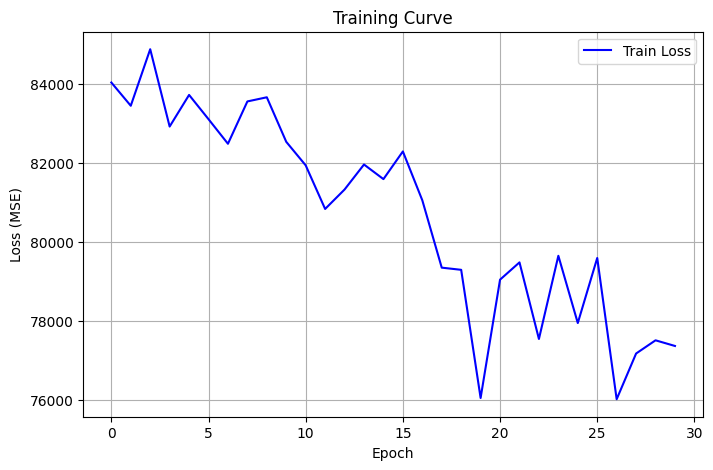


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 320.537 ft
Final Displacement Error (FDE): 420.815 ft


In [21]:
trained_model_11 = train_and_evaluate(model1, metric = 'mse', train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=30)
trained_model_12 = train_and_evaluate(model1, metric = 'mse', train_dataset=dataset_normalised, val_dataset=val_data_normalised, device="cuda", epochs=30)

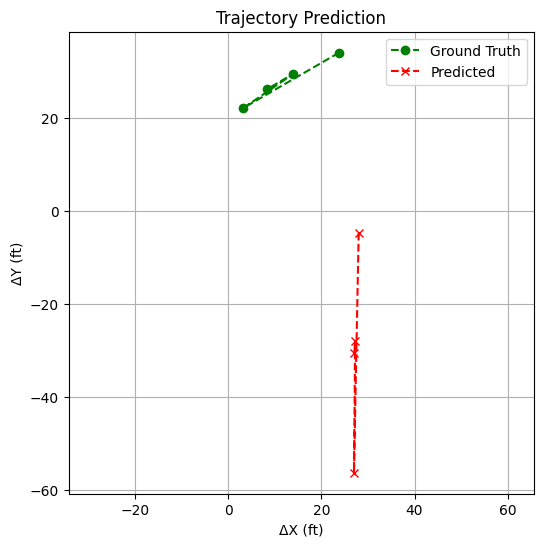

Average Displacement Error (ADE): 59.842 ft
Final Displacement Error (FDE): 59.744 ft


In [23]:
true_coords, pred_coords = visualize_prediction(trained_model_11, val_data[0], device="cuda")

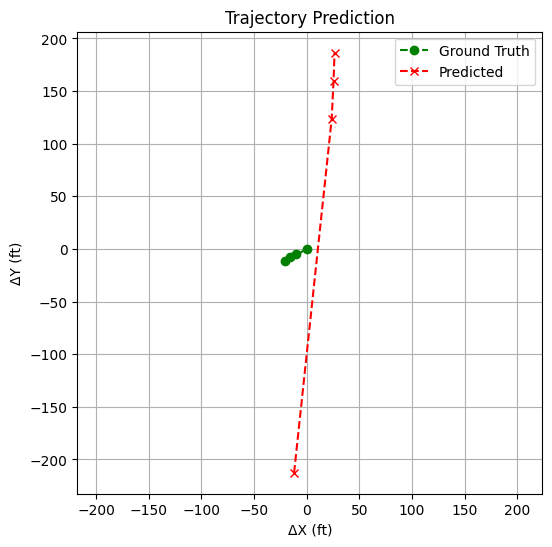

Average Displacement Error (ADE): 180.496 ft
Final Displacement Error (FDE): 198.728 ft


In [24]:
true_coords, pred_coords = visualize_prediction(trained_model_12, val_data_normalised[0], device="cuda")

Epoch 1/30 | Train Loss: 164.0215
Epoch 2/30 | Train Loss: 164.5936
Epoch 3/30 | Train Loss: 163.8684
Epoch 4/30 | Train Loss: 163.7001
Epoch 5/30 | Train Loss: 164.3676
Epoch 6/30 | Train Loss: 162.4228
Epoch 7/30 | Train Loss: 163.6743
Epoch 8/30 | Train Loss: 163.1202
Epoch 9/30 | Train Loss: 164.5477
Epoch 10/30 | Train Loss: 160.5673
Epoch 11/30 | Train Loss: 159.4280
Epoch 12/30 | Train Loss: 159.3261
Epoch 13/30 | Train Loss: 159.2307
Epoch 14/30 | Train Loss: 160.4774
Epoch 15/30 | Train Loss: 156.7428
Epoch 16/30 | Train Loss: 156.4558
Epoch 17/30 | Train Loss: 157.3372
Epoch 18/30 | Train Loss: 157.6751
Epoch 19/30 | Train Loss: 159.0355
Epoch 20/30 | Train Loss: 160.1029
Epoch 21/30 | Train Loss: 161.7335
Epoch 22/30 | Train Loss: 158.9163
Epoch 23/30 | Train Loss: 157.1200
Epoch 24/30 | Train Loss: 155.0735
Epoch 25/30 | Train Loss: 156.2908
Epoch 26/30 | Train Loss: 154.1138
Epoch 27/30 | Train Loss: 156.8132
Epoch 28/30 | Train Loss: 156.8964
Epoch 29/30 | Train Loss: 160

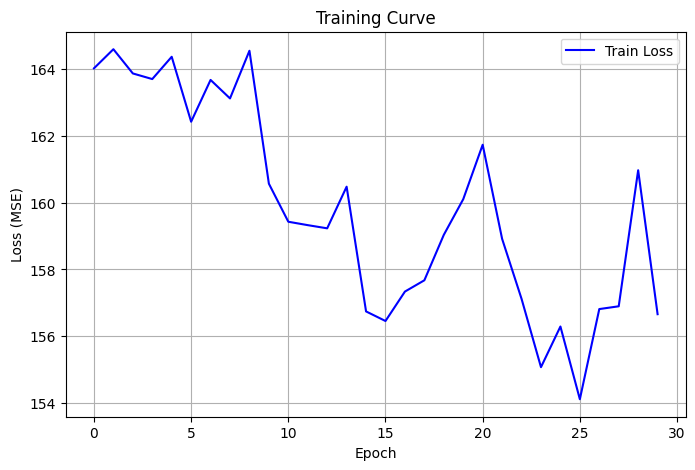


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 286.510 ft
Final Displacement Error (FDE): 336.010 ft
Epoch 1/30 | Train Loss: 155.1447
Epoch 2/30 | Train Loss: 154.8171
Epoch 3/30 | Train Loss: 155.0951
Epoch 4/30 | Train Loss: 158.0270
Epoch 5/30 | Train Loss: 157.3103
Epoch 6/30 | Train Loss: 159.0804
Epoch 7/30 | Train Loss: 159.2442
Epoch 8/30 | Train Loss: 158.3509
Epoch 9/30 | Train Loss: 156.6433
Epoch 10/30 | Train Loss: 158.0378
Epoch 11/30 | Train Loss: 157.0789
Epoch 12/30 | Train Loss: 157.0137
Epoch 13/30 | Train Loss: 154.7789
Epoch 14/30 | Train Loss: 157.5541
Epoch 15/30 | Train Loss: 155.5349
Epoch 16/30 | Train Loss: 155.9483
Epoch 17/30 | Train Loss: 155.9062
Epoch 18/30 | Train Loss: 155.7634
Epoch 19/30 | Train Loss: 154.1079
Epoch 20/30 | Train Loss: 154.0630
Epoch 21/30 | Train Loss: 155.5031
Epoch 22/30 | Train Loss: 157.2448
Epoch 23/30 | Train Loss: 157.2284
Epoch 24/30 | Train Loss: 155.8033
Epoch 25/30 | Train Loss: 156.9624
Epoch 26/

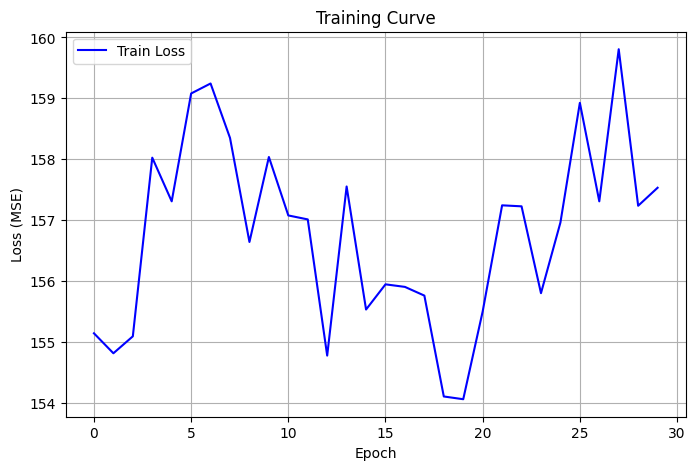


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 330.494 ft
Final Displacement Error (FDE): 427.521 ft


In [22]:
trained_model_13 = train_and_evaluate(model1, metric = 'huber', train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=30)
trained_model_14 = train_and_evaluate(model1, metric = 'huber', train_dataset=dataset_normalised, val_dataset=val_data_normalised, device="cuda", epochs=30)

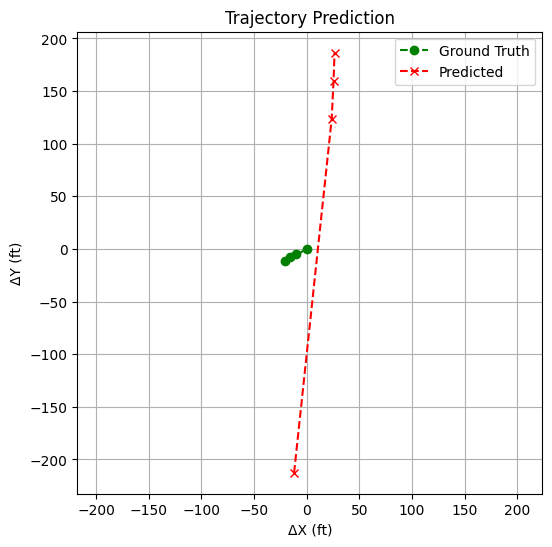

Average Displacement Error (ADE): 180.496 ft
Final Displacement Error (FDE): 198.728 ft


In [25]:
true_coords, pred_coords = visualize_prediction(trained_model_14, val_data_normalised[0], device="cuda")

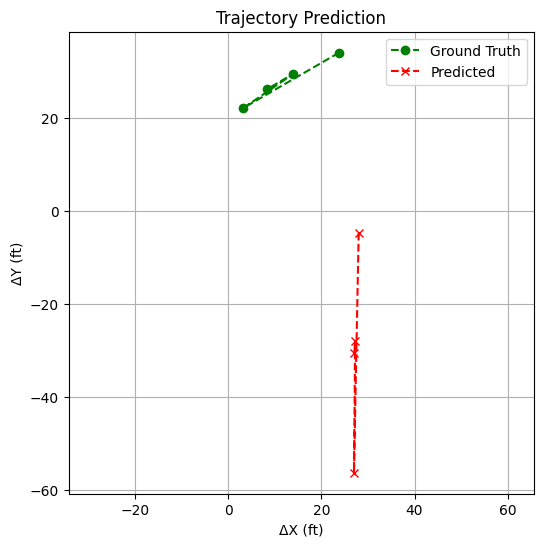

Average Displacement Error (ADE): 59.842 ft
Final Displacement Error (FDE): 59.744 ft


In [26]:
true_coords, pred_coords = visualize_prediction(trained_model_13, val_data[0], device="cuda")

Epoch 1/50 | Train Loss: 205068.7916
Epoch 2/50 | Train Loss: 187229.9518
Epoch 3/50 | Train Loss: 166615.1156
Epoch 4/50 | Train Loss: 151881.4851
Epoch 5/50 | Train Loss: 138941.0021
Epoch 6/50 | Train Loss: 127817.0884
Epoch 7/50 | Train Loss: 120891.9470
Epoch 8/50 | Train Loss: 115050.3295
Epoch 9/50 | Train Loss: 113798.5063
Epoch 10/50 | Train Loss: 109528.2220
Epoch 11/50 | Train Loss: 110607.4408
Epoch 12/50 | Train Loss: 100912.5927
Epoch 13/50 | Train Loss: 102963.2230
Epoch 14/50 | Train Loss: 97171.6061
Epoch 15/50 | Train Loss: 98374.0348
Epoch 16/50 | Train Loss: 95538.0217
Epoch 17/50 | Train Loss: 94477.5475
Epoch 18/50 | Train Loss: 90697.9085
Epoch 19/50 | Train Loss: 90152.4633
Epoch 20/50 | Train Loss: 88088.4072
Epoch 21/50 | Train Loss: 87841.9193
Epoch 22/50 | Train Loss: 87240.2346
Epoch 23/50 | Train Loss: 87325.3864
Epoch 24/50 | Train Loss: 88394.7541
Epoch 25/50 | Train Loss: 87226.1429
Epoch 26/50 | Train Loss: 88181.8052
Epoch 27/50 | Train Loss: 85589.73

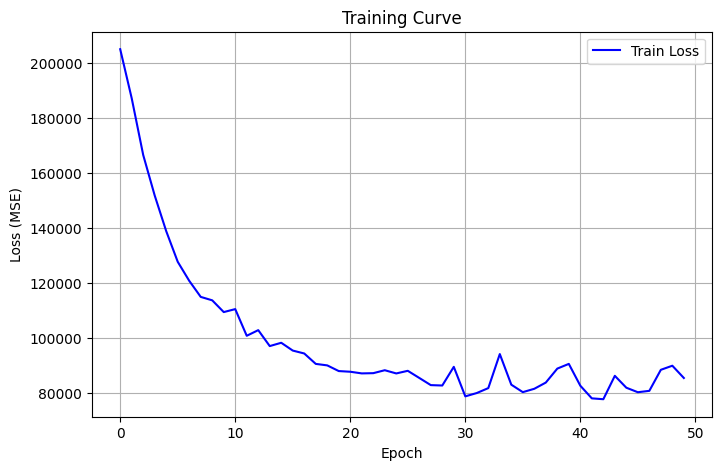


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 340.876 ft
Final Displacement Error (FDE): 364.791 ft
Epoch 1/50 | Train Loss: 88663.0400
Epoch 2/50 | Train Loss: 98052.3368
Epoch 3/50 | Train Loss: 91862.4841
Epoch 4/50 | Train Loss: 93480.2405
Epoch 5/50 | Train Loss: 89484.3251
Epoch 6/50 | Train Loss: 90220.1578
Epoch 7/50 | Train Loss: 89302.2683
Epoch 8/50 | Train Loss: 88782.1666
Epoch 9/50 | Train Loss: 101508.9178
Epoch 10/50 | Train Loss: 91378.9251
Epoch 11/50 | Train Loss: 90681.7684
Epoch 12/50 | Train Loss: 88445.2957
Epoch 13/50 | Train Loss: 94020.9367
Epoch 14/50 | Train Loss: 91001.1799
Epoch 15/50 | Train Loss: 89816.5328
Epoch 16/50 | Train Loss: 89293.2546
Epoch 17/50 | Train Loss: 87408.2067
Epoch 18/50 | Train Loss: 87467.7935
Epoch 19/50 | Train Loss: 86109.8170
Epoch 20/50 | Train Loss: 88711.3216
Epoch 21/50 | Train Loss: 90785.1745
Epoch 22/50 | Train Loss: 93987.0710
Epoch 23/50 | Train Loss: 103753.8556
Epoch 24/50 | Train Loss: 96655

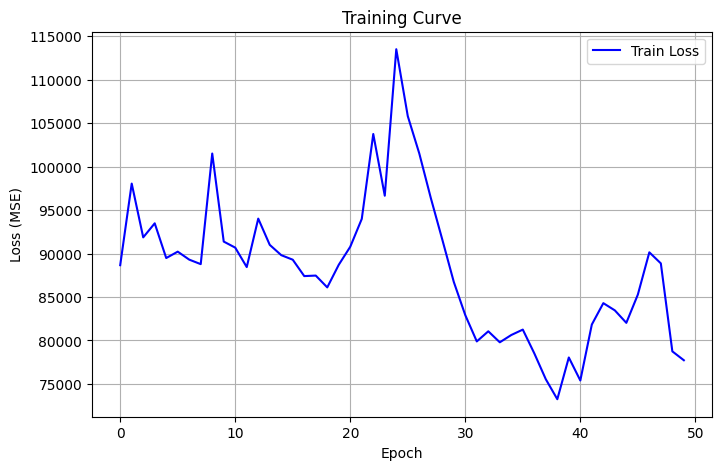


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 505.940 ft
Final Displacement Error (FDE): 589.391 ft


In [55]:
trained_model_21 = train_and_evaluate(model2, metric = 'mse', train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=50)
trained_model_22 = train_and_evaluate(model2, metric = 'mse', train_dataset=dataset_normalised, val_dataset=val_data_normalised, device="cuda", epochs=50)


Epoch 1/50 | Train Loss: 168.5545
Epoch 2/50 | Train Loss: 168.6795
Epoch 3/50 | Train Loss: 164.9171
Epoch 4/50 | Train Loss: 154.9610
Epoch 5/50 | Train Loss: 160.9860
Epoch 6/50 | Train Loss: 171.1125
Epoch 7/50 | Train Loss: 163.4892
Epoch 8/50 | Train Loss: 172.0320
Epoch 9/50 | Train Loss: 183.0105
Epoch 10/50 | Train Loss: 184.6779
Epoch 11/50 | Train Loss: 177.0591
Epoch 12/50 | Train Loss: 175.2484
Epoch 13/50 | Train Loss: 195.3815
Epoch 14/50 | Train Loss: 190.4592
Epoch 15/50 | Train Loss: 191.5946
Epoch 16/50 | Train Loss: 187.7303
Epoch 17/50 | Train Loss: 189.8561
Epoch 18/50 | Train Loss: 174.7001
Epoch 19/50 | Train Loss: 172.8195
Epoch 20/50 | Train Loss: 167.4643
Epoch 21/50 | Train Loss: 163.2844
Epoch 22/50 | Train Loss: 163.1986
Epoch 23/50 | Train Loss: 169.6981
Epoch 24/50 | Train Loss: 171.1560
Epoch 25/50 | Train Loss: 164.0553
Epoch 26/50 | Train Loss: 170.8811
Epoch 27/50 | Train Loss: 169.3879
Epoch 28/50 | Train Loss: 171.1488
Epoch 29/50 | Train Loss: 167

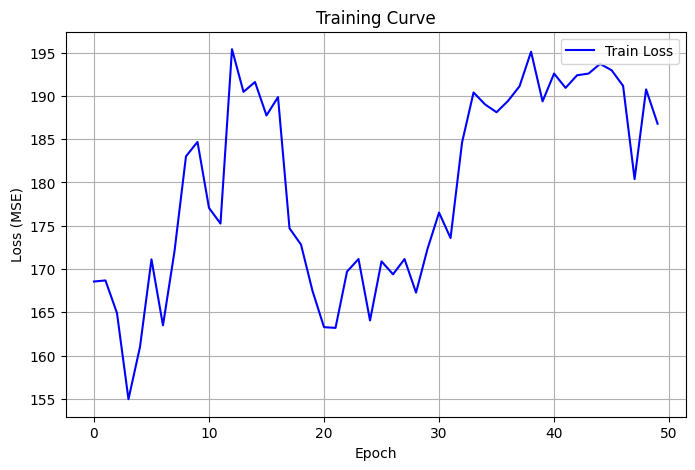


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 358.582 ft
Final Displacement Error (FDE): 378.773 ft
Epoch 1/50 | Train Loss: 183.3281
Epoch 2/50 | Train Loss: 176.9723
Epoch 3/50 | Train Loss: 174.3952
Epoch 4/50 | Train Loss: 174.7054
Epoch 5/50 | Train Loss: 172.6006
Epoch 6/50 | Train Loss: 172.6639
Epoch 7/50 | Train Loss: 171.8140
Epoch 8/50 | Train Loss: 184.7692
Epoch 9/50 | Train Loss: 191.4759
Epoch 10/50 | Train Loss: 192.6103
Epoch 11/50 | Train Loss: 194.2283
Epoch 12/50 | Train Loss: 192.5587
Epoch 13/50 | Train Loss: 185.5325
Epoch 14/50 | Train Loss: 183.9107
Epoch 15/50 | Train Loss: 186.6228
Epoch 16/50 | Train Loss: 185.8291
Epoch 17/50 | Train Loss: 185.2847
Epoch 18/50 | Train Loss: 184.3083
Epoch 19/50 | Train Loss: 185.6192
Epoch 20/50 | Train Loss: 188.2571
Epoch 21/50 | Train Loss: 184.3421
Epoch 22/50 | Train Loss: 183.6434
Epoch 23/50 | Train Loss: 184.2105
Epoch 24/50 | Train Loss: 187.1147
Epoch 25/50 | Train Loss: 186.6656
Epoch 26/

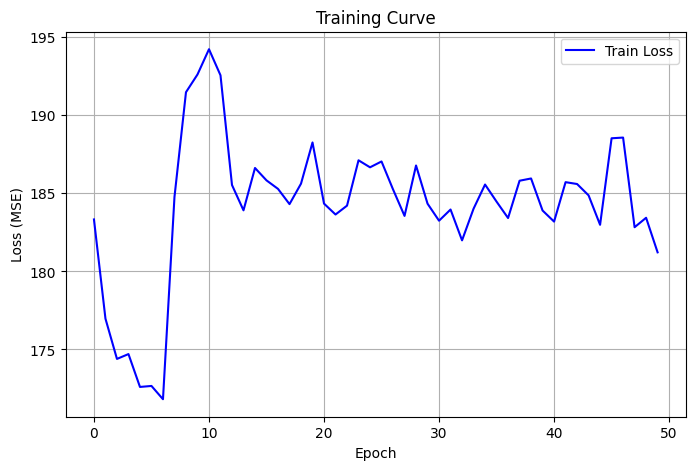


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 634.155 ft
Final Displacement Error (FDE): 653.743 ft


In [56]:
trained_model_23 = train_and_evaluate(model2, metric = 'huber', train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=50)
trained_model_24 = train_and_evaluate(model2, metric = 'huber', train_dataset=dataset_normalised, val_dataset=val_data_normalised, device="cuda", epochs=50)


Epoch 1/30 | Train Loss: 302767.2098
Epoch 2/30 | Train Loss: 146573.1770
Epoch 3/30 | Train Loss: 110316.7041
Epoch 4/30 | Train Loss: 102806.6223
Epoch 5/30 | Train Loss: 100989.3131
Epoch 6/30 | Train Loss: 102723.5774
Epoch 7/30 | Train Loss: 99158.0886
Epoch 8/30 | Train Loss: 100375.8561
Epoch 9/30 | Train Loss: 98897.8798
Epoch 10/30 | Train Loss: 96287.7782
Epoch 11/30 | Train Loss: 95618.4484
Epoch 12/30 | Train Loss: 96261.9669
Epoch 13/30 | Train Loss: 103118.5785
Epoch 14/30 | Train Loss: 96084.1808
Epoch 15/30 | Train Loss: 98520.6434
Epoch 16/30 | Train Loss: 97892.2852
Epoch 17/30 | Train Loss: 95565.4344
Epoch 18/30 | Train Loss: 95761.1472
Epoch 19/30 | Train Loss: 92574.0947
Epoch 20/30 | Train Loss: 92549.4648
Epoch 21/30 | Train Loss: 91767.2684
Epoch 22/30 | Train Loss: 87524.7984
Epoch 23/30 | Train Loss: 92683.4470
Epoch 24/30 | Train Loss: 89944.2865
Epoch 25/30 | Train Loss: 92617.0669
Epoch 26/30 | Train Loss: 96106.5022
Epoch 27/30 | Train Loss: 104966.2069
E

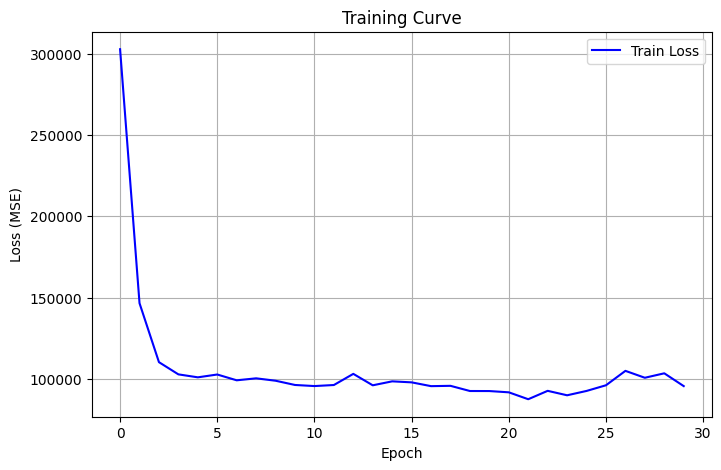


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 367.717 ft
Final Displacement Error (FDE): 368.180 ft
Epoch 1/30 | Train Loss: 95376.0434
Epoch 2/30 | Train Loss: 94684.5505
Epoch 3/30 | Train Loss: 93041.9029
Epoch 4/30 | Train Loss: 91645.4569
Epoch 5/30 | Train Loss: 94339.9202
Epoch 6/30 | Train Loss: 92479.4028
Epoch 7/30 | Train Loss: 91269.3392
Epoch 8/30 | Train Loss: 108257.1053
Epoch 9/30 | Train Loss: 113129.1193
Epoch 10/30 | Train Loss: 110990.9188
Epoch 11/30 | Train Loss: 109538.5823
Epoch 12/30 | Train Loss: 109896.0008
Epoch 13/30 | Train Loss: 111212.0783
Epoch 14/30 | Train Loss: 109866.7820
Epoch 15/30 | Train Loss: 108705.9054
Epoch 16/30 | Train Loss: 107802.1693
Epoch 17/30 | Train Loss: 109400.9099
Epoch 18/30 | Train Loss: 108916.5252
Epoch 19/30 | Train Loss: 109510.9068
Epoch 20/30 | Train Loss: 107641.6103
Epoch 21/30 | Train Loss: 105801.5066
Epoch 22/30 | Train Loss: 109720.2414
Epoch 23/30 | Train Loss: 109185.2828
Epoch 24/30 | Tra

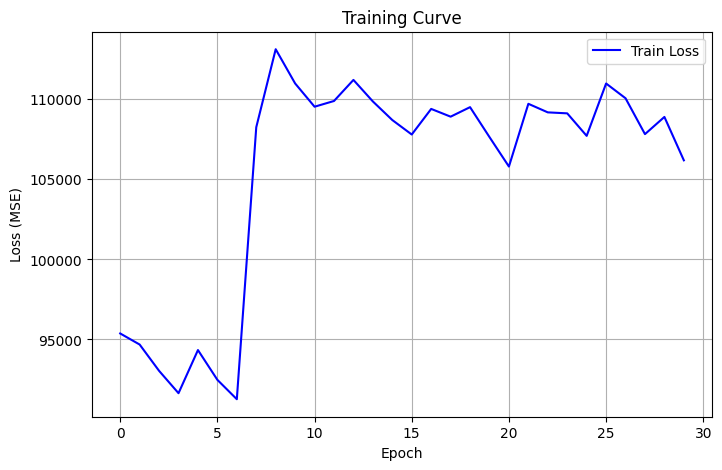


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 619.856 ft
Final Displacement Error (FDE): 655.381 ft


In [32]:
trained_model_31 = train_and_evaluate(Attn_model, metric = 'mse', train_dataset=dataset, val_dataset=val_data, tf = 'Yes', device="cuda", epochs=30)
trained_model_32 = train_and_evaluate(Attn_model, metric = 'mse', train_dataset=dataset_normalised, val_dataset=val_data_normalised, tf = 'Yes', device="cuda", epochs=30)

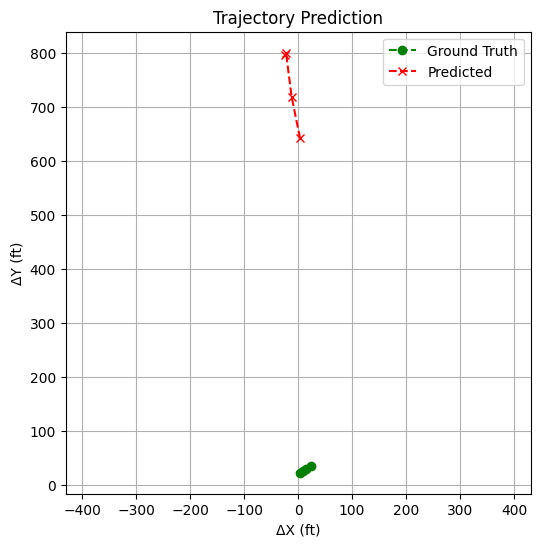

Average Displacement Error (ADE): 711.466 ft
Final Displacement Error (FDE): 769.671 ft


In [35]:
true_coords, pred_coords = visualize_prediction(trained_model_32, val_data[0], device="cuda")

Epoch 1/30 | Train Loss: 207.9476
Epoch 2/30 | Train Loss: 204.7240
Epoch 3/30 | Train Loss: 206.6621
Epoch 4/30 | Train Loss: 207.2844
Epoch 5/30 | Train Loss: 207.1960
Epoch 6/30 | Train Loss: 203.9046
Epoch 7/30 | Train Loss: 204.8010
Epoch 8/30 | Train Loss: 201.6337
Epoch 9/30 | Train Loss: 204.8609
Epoch 10/30 | Train Loss: 204.9793
Epoch 11/30 | Train Loss: 204.0733
Epoch 12/30 | Train Loss: 201.5963
Epoch 13/30 | Train Loss: 201.1850
Epoch 14/30 | Train Loss: 204.7700
Epoch 15/30 | Train Loss: 202.7074
Epoch 16/30 | Train Loss: 204.5073
Epoch 17/30 | Train Loss: 204.3228
Epoch 18/30 | Train Loss: 203.3382
Epoch 19/30 | Train Loss: 201.6869
Epoch 20/30 | Train Loss: 202.1341
Epoch 21/30 | Train Loss: 204.3749
Epoch 22/30 | Train Loss: 202.2885
Epoch 23/30 | Train Loss: 201.4335
Epoch 24/30 | Train Loss: 204.0997
Epoch 25/30 | Train Loss: 203.1851
Epoch 26/30 | Train Loss: 203.3119
Epoch 27/30 | Train Loss: 200.3590
Epoch 28/30 | Train Loss: 199.8696
Epoch 29/30 | Train Loss: 199

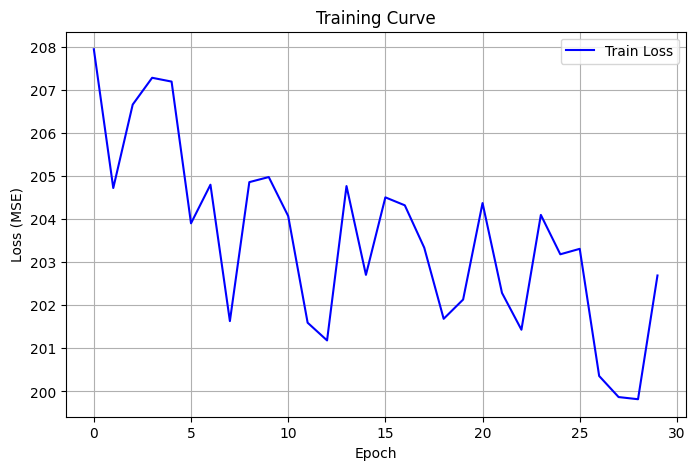


Final Evaluation on Validation Set:
Average Displacement Error (ADE): 417.623 ft
Final Displacement Error (FDE): 422.538 ft


In [36]:
trained_model_33 = train_and_evaluate(Attn_model, metric = 'huber', train_dataset=dataset, val_dataset=val_data,tf = 'Yes', device="cuda", epochs=30)


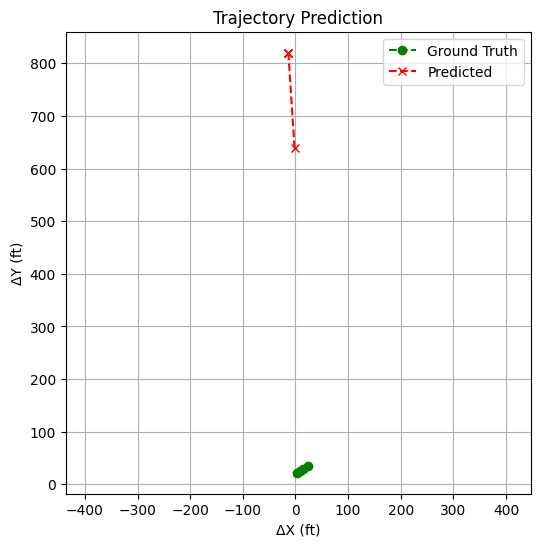

Average Displacement Error (ADE): 747.124 ft
Final Displacement Error (FDE): 794.080 ft


In [37]:
true_coords, pred_coords = visualize_prediction(trained_model_33, val_data[0], device="cuda")

In [ ]:
trained_model_33 = train_and_evaluate(Attn_model, metric = 'huber', train_dataset=dataset, val_dataset=val_data,tf = 'Yes', device="cuda", epochs=30)
trained_model_34 = train_and_evaluate(Attn_model, metric = 'huber', train_dataset=dataset_normalised, val_dataset=val_data_normalised, tf = 'Yes', device="cuda", epochs=30)

In [31]:
# trained_model = train_and_evaluate(Attn_model, train_dataset=dataset, val_dataset=val_data, device="cuda", epochs=20)


KeyboardInterrupt: 

**Define Two Training Runs
Train two identical models:

One with MSE Loss (nn.MSELoss)

One with Huber Loss (nn.SmoothL1Loss)**

In [51]:
# Common setup
from copy import deepcopy

base_model = GATGRUWithAttention(in_channels=5, hidden_dim=64, future_steps=4, teacher_forcing_ratio=0.5)
base_optimizer = torch.optim.Adam(base_model.parameters(), lr=1e-3)
num_epochs = 10
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for graph_seqs, future_coords_batch in dataloader:
            graph_seq = [g.to(device) for g in graph_seqs[0]]
            future_coords = future_coords_batch[0].to(device)
            pred = model(graph_seq)
            loss = criterion(pred, future_coords)
            total_loss += loss.item()
    return total_loss / len(dataloader)
# MSE Training
model_mse = deepcopy(base_model).to("cuda")
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=1e-3)
criterion_mse = nn.MSELoss()

# Huber Training
model_huber = deepcopy(base_model).to("cuda")
optimizer_huber = torch.optim.Adam(model_huber.parameters(), lr=1e-3)
criterion_huber = nn.SmoothL1Loss()  # Huber

train_losses_mse, val_losses_mse = [], []
train_losses_huber, val_losses_huber = [], []

for epoch in range(num_epochs):
    model_mse, train_loss = train_one_epoch(model_mse, train_loader, optimizer_mse, criterion_mse, "cuda")
    val_loss = evaluate(model_mse, val_loader, criterion_mse, "cuda")
    train_losses_mse.append(train_loss)
    val_losses_mse.append(val_loss)

    model_huber, train_loss = train_one_epoch(model_huber, train_loader, optimizer_huber, criterion_huber, "cuda")
    val_loss = evaluate(model_huber, val_loader, criterion_huber, "cuda")
    train_losses_huber.append(train_loss)
    val_losses_huber.append(val_loss)


plt.plot(train_losses_mse, label="Train MSE")
plt.plot(val_losses_mse, label="Val MSE")
plt.plot(train_losses_huber, label="Train Huber")
plt.plot(val_losses_huber, label="Val Huber")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("MSE vs Huber Loss Comparison")
plt.show()


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**####################################################################################**

In [ ]:
import wandb
wandb.login(key='bb3c7761be2856a8335d16d1483149380482ae9e')

In [27]:
def train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        # Model and optimizer
        model = GATGRUEncoderDecoder(
            in_channels=5, 
            hidden_dim=config.hidden_dim
        ).to("cuda")
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.MSELoss()

        for epoch in range(config.epochs):
            loss = train_one_epoch(model, dataloader, optimizer, criterion, device="cuda")
            wandb.log({"epoch": epoch+1, "loss": loss})

# Sweep configuration
sweep_config = {
    'method': 'random',
    'metric': {'name': 'loss', 'goal': 'minimize'},
    'parameters': 
    {
        'hidden_dim': {'values': [32, 64, 128]},
        'lr': {'value': 1e-3},
        # 'lr': {'min': 1e-5, 'max': 1e-3},
        'epochs': {'value': 10}
     }
}

# Initialize and run
sweep_id = wandb.sweep(sweep_config, project="trajectory-forecasting")
wandb.agent(sweep_id, function=train, count=2)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ol6sgwxk
Sweep URL: https://wandb.ai/abanisingha1997/trajectory-forecasting/sweeps/ol6sgwxk


epoch,▆▇▁▇▁▇▂█▂█
loss,▃▃█▃█▂█▁█▁
epoch,22
loss,86415.54355


wandb: ERROR Run 55miuhac errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 300, in _run_job
wandb: ERROR     wandb.teardown()
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_setup.py", line 391, in teardown
wandb: ERROR     orig_singleton._teardown(exit_code=exit_code)
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/wandb_setup.py", line 253, in _teardown
wandb: ERROR     internal_exit_code = self._connection.teardown(exit_code or 0)
wandb: ERROR                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/lib/service_connection.py", line 197, in teardown
wandb: ERROR     raise WandbServiceNotOwnedError(
wandb: ERROR wandb.sdk.lib.service_connection.WandbServiceNotOwnedError: Cannot tear down service started by different process
wandb: ERROR 
wandb: Agent Start

Traceback (most recent call last):
  File "/tmp/ipykernel_31/4283352274.py", line 15, in train
    wandb.log({"epoch": epoch+1, "loss": loss})
  File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/lib/preinit.py", line 36, in preinit_wrapper
    raise wandb.Error(f"You must call wandb.init() before {name}()")
wandb.errors.errors.Error: You must call wandb.init() before wandb.log()
wandb: ERROR Run s7z5qq45 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/tmp/ipykernel_31/4283352274.py", line 15, in train
wandb: ERROR     wandb.log({"epoch": epoch+1, "loss": loss})
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/sdk/lib/preinit.py", line 36, in preinit_wrapper
wandb: ERROR     raise wandb.Error(f"You must call wandb.init() before {name}()")
wandb: ERROR wandb.errors.errors.Error: You must call wandb.init() before wandb.log()
wandb: ERROR 
wandb: ERROR During handling of the above exception, another exception occurred:
wandb: ERROR 
wa